In [1]:
%pylab inline
font = {'size':13, 'family':'serif'}
matplotlib.rc('font', **font)

Populating the interactive namespace from numpy and matplotlib


# Computing the CM 

## Basic approach:

In [2]:
# Random points in a sphere:

r = random.random(1000) 
theta = random.random(1000) * 2 - 1
phi = random.random(1000) * 2 * np.pi

x1 = r**(1/3.0) * sin(arccos(theta)) * sin(phi)
y1 = r**(1/3.0) * sin(arccos(theta)) * cos(phi)
z1 = r**(1/3.0) * theta

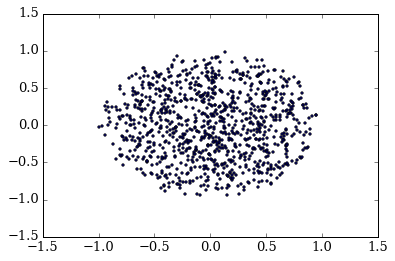

In [3]:
scatter(x1, z1, s=5)

In [4]:
# CM coordinates:
xCM = sum(x1)/len(x1)
yCM = sum(y1)/len(y1)
zCM = sum(z1)/len(z1)

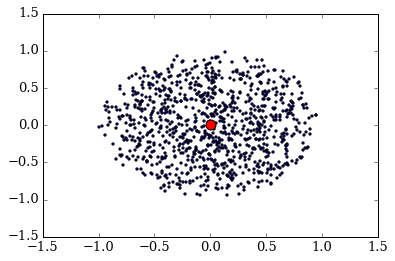

In [5]:
scatter(x1, z1, s=5)
scatter(xCM, zCM, s=100, c='r')

## Iterative approach:


In [6]:
def CM(x, y, z, xCM, yCM, zCM, delta):
    xCM = sum(x)/len(x)
    yCM = sum(y)/len(y)
    zCM = sum(z)/len(z)

    xCM_new = xCM
    yCM_new = yCM
    zCM_new = zCM

    xCM = 0.0
    yCM = 0.0
    zCM = 0.0

    while (np.sqrt((xCM_new-xCM)**2 + (yCM_new-yCM)**2 +(zCM_new-zCM)**2) > delta):
        xCM = xCM_new
        yCM = yCM_new
        zCM = zCM_new
        Rcm = np.sqrt(xCM**2 + yCM**2 + zCM**2)
        r = np.sqrt(x**2 + y**2 + z**2)
        R = np.sqrt((x - xCM)**2 + (y - yCM)**2 + (z - zCM)**2)
        Rmax = max(R)
        index = where(r<Rmax/2)
        x = x[index]
        y = y[index]
        z = z[index]
        #print Rmax
        xCM_new = sum(x)/len(x)
        yCM_new = sum(y)/len(y)
        zCM_new = sum(z)/len(z)
        #scatter(xCM_new, yCM_new)
    return xCM_new, yCM_new, zCM_new

In [7]:
CM(x1, y1, z1, 0, 0, 0, 0.5)


(0.0089819071862683678, 0.0023520172351647502, 0.0044708132429203623)

# Testing the code in a simulation snapshot:

In [8]:
from pygadgetreader import *

In [23]:
#positions = readsnap("../../data/LMCMW/MW1LMC4/MW1LMC4_000", 'pos', 'dm')
velocities = readsnap("../../data/LMCMW/MW1LMC4/snapshots/MW1LMC4_000", 'vel', 'dm')
#particles_ids = readsnap("../../data/LMCMW/MW1LMC4/ICs1/MW1LMC4_000", 'pid', 'dm')

Returning DM    Velocities


In [11]:
X = sort(particles_ids)
limit = X[29999]
index_mw = where(particles_ids<=49376)
index_LMC = where(particles_ids>49376)

In [20]:
print X
print limit
print len(X)
print int(len(X)/2.0 - 1.0)

[    1     2     3 ..., 79998 79999 80000]
49376
60000
29999


In [16]:
x_sim_mw = positions[index_mw[0],0]
y_sim_mw = positions[index_mw[0],1]
z_sim_mw = positions[index_mw[0],2]

x_sim_lmc = positions[index_LMC[0],0]
y_sim_lmc = positions[index_LMC[0],1]
z_sim_lmc = positions[index_LMC[0],2]

print len(x_sim_mw), len(x_sim_lmc)

30000 30000


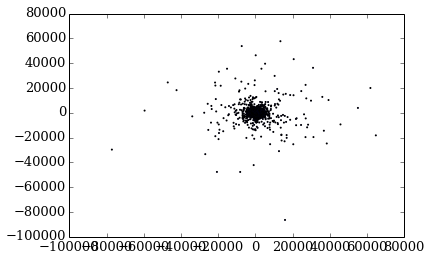

In [17]:
scatter(x_sim_mw, z_sim_mw, s=1.0)

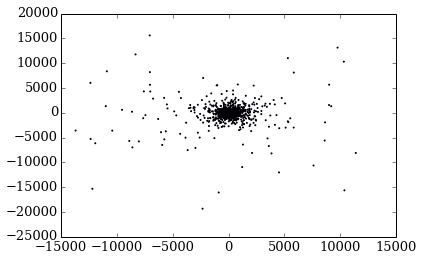

In [18]:
scatter(x_sim_lmc, z_sim_lmc, s=1.0)

In [19]:
X_sim_mwCM, Y_sim_mwCM, Z_sim_mwCM = CM(x_sim_mw, y_sim_mw, z_sim_mw, 0, 0, 0, 10)
X_sim_lmcCM, Y_sim_lmcCM, Z_sim_lmcCM = CM(x_sim_lmc, y_sim_lmc, z_sim_lmc, 0, 0, 0, 10)

In [20]:
print X_sim_mwCM, Y_sim_mwCM, Z_sim_mwCM
print X_sim_lmcCM, Y_sim_lmcCM, Z_sim_lmcCM

7.6432793838 -8.51729311236 1.3219704473
40.7491322052 246.955091619 -73.6265895664


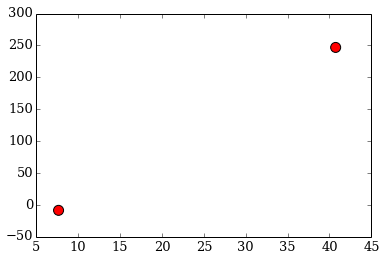

In [21]:
scatter(X_sim_mwCM, Y_sim_mwCM, c='r', s=100)
scatter(X_sim_lmcCM, Y_sim_lmcCM, c='r', s=100)